In [1]:
import numpy as np
import itertools
from Environment import Easy21
import matplotlib.pyplot as plt
from utils import *

In [43]:
def binary_feature(state, action):
    
    def turn_couple_to_index(couple):
        [a,d,p] = couple
        return 3*6*a + 6*d + p
    
    binary_feature_vector = np.zeros((2*3*6,1))
    dealer, player_sum = state["dealer"], state["player_sum"]
    dealer_intervals = [[1,4], [4,7],[7,10]]
    dealer_cuboids = [np.linspace(dealer_interval[0], dealer_interval[1], dealer_interval[1]-dealer_interval[0]+1) for dealer_interval in dealer_intervals]
    player_intervals = [[1,6], [4,9], [7,12], [10,15], [13,18], [16,21]]
    player_cuboids = [np.linspace(player_interval[0], player_interval[1], player_interval[1]-player_interval[0]+1) for player_interval in player_intervals]    
    
    dealer_to_activate, player_to_activate = [], []
    action_to_activate = [action]
    
    for k,dealer_cuboid in enumerate(dealer_cuboids):
        if dealer in dealer_cuboid:
            dealer_to_activate.append(k)
    for j,player_cuboid in enumerate(player_cuboids):
        if player_sum in player_cuboid:
            player_to_activate.append(j)
    couples = list(itertools.product(action_to_activate, dealer_to_activate, player_to_activate))
    index_couples = [turn_couple_to_index(couple) for couple in couples]
    for index in index_couples:
        binary_feature_vector[index]=1
    return binary_feature_vector

In [44]:
state = {"dealer":9, "player_sum":17}
binary_feature(state, 0).reshape(-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [75]:
def Q(state, action, theta):
    return np.dot(binary_feature(state, action).transpose(), theta)

def policy_epsilon_greedy2(state, theta, epsilon):
        """Pick action epsilon-greedily"""
        value_hit, value_stick = Q(state, 0, theta), Q(state, 1, theta)
        p = np.random.binomial(1,epsilon)
        max_index = np.argmax([value_hit, value_stick])
        min_index = np.argmin([value_hit, value_stick])
        if max_index!=min_index:
            if p == 0:
                index_action = max_index

            else:
                index_action = min_index
        else:
             index_action = np.random.binomial(1,0.5)
        return index_action

def get_value_from_theta(theta):
    value = np.zeros((10,21))
    for i in range(1,11):
        for j in range(1,22):
            q_ij_0 = Q({"dealer":i, "player_sum":j}, 0, theta)
            q_ij_1 = Q({"dealer":i, "player_sum":j}, 1, theta)
            value[i-1,j-1] = np.maximum(q_ij_0, q_ij_1)
    return value

In [79]:
def Sarsa_Q_approx(iterations, it_conf, discount_factor, Lambda,alpha, epsilon,  value_star):
    """Implements SARSA(Lambda) using Q function approximation"""
    MSEs = []
    actions = ["Hit", "Stick"]
    
    theta =  np.zeros((3*6*2,1))
    eligibility_traces = None 
   
    for it in range(iterations):
        if it%it_conf == 0:
            print("iteration:{}/{}".format(it, iterations))
        """plays one episode"""
        eligibility_traces = np.zeros((3*6*2,1))
        game = Easy21()
        
        first_state = game.state

        index_action = policy_epsilon_greedy2(first_state, theta, epsilon)
        """plays game epsilon-greedily"""
        while game.isTerminal == False:
            
            last_state = game.state
            dealer, player_sum = last_state["dealer"], last_state["player_sum"]

            pick_action = actions[index_action]
            
            _,reward = game.step(pick_action)
            binary_feat = binary_feature(last_state, index_action)
            eligibility_traces += binary_feat
            if game.isTerminal == False:
                next_state = game.state
                next_index_action = policy_epsilon_greedy2(next_state, theta, epsilon)
                target = reward + discount_factor * Q(next_state, next_index_action, theta)
                

            else: 
                target = reward
            delta = target - Q(state, index_action, theta)
            
            
            ##We update the weight vector
            eligibility_traces = discount_factor * Lambda * eligibility_traces  
            delta_tot = eligibility_traces * delta  * alpha 
            theta += delta_tot
            if game.isTerminal == False:
                index_action = next_index_action
        """episode ended"""
       
        error_episode = np.linalg.norm(get_value_from_theta(theta)-get_value(value_star))**2 / ( 22 * 10)
        MSEs.append(error_episode)
    return MSEs, theta

In [95]:
value_star = np.load("results/actionvalue_montecarlo.npy")
iterations,it_conf = int(2e3), int(5e1)
lambdas = 0.9
epsilon = 0.05
alpha = 0.01
discount_factor = 1
MSEs, theta  = Sarsa_Q_approx(iterations, it_conf, discount_factor, lambdas, alpha,epsilon, value_star)

iteration:0/2000
iteration:50/2000
iteration:100/2000
iteration:150/2000
iteration:200/2000
iteration:250/2000
iteration:300/2000
iteration:350/2000
iteration:400/2000
iteration:450/2000
iteration:500/2000
iteration:550/2000
iteration:600/2000
iteration:650/2000
iteration:700/2000
iteration:750/2000
iteration:800/2000
iteration:850/2000
iteration:900/2000
iteration:950/2000
iteration:1000/2000
iteration:1050/2000
iteration:1100/2000
iteration:1150/2000
iteration:1200/2000
iteration:1250/2000
iteration:1300/2000
iteration:1350/2000
iteration:1400/2000
iteration:1450/2000
iteration:1500/2000
iteration:1550/2000
iteration:1600/2000
iteration:1650/2000
iteration:1700/2000
iteration:1750/2000
iteration:1800/2000
iteration:1850/2000
iteration:1900/2000
iteration:1950/2000


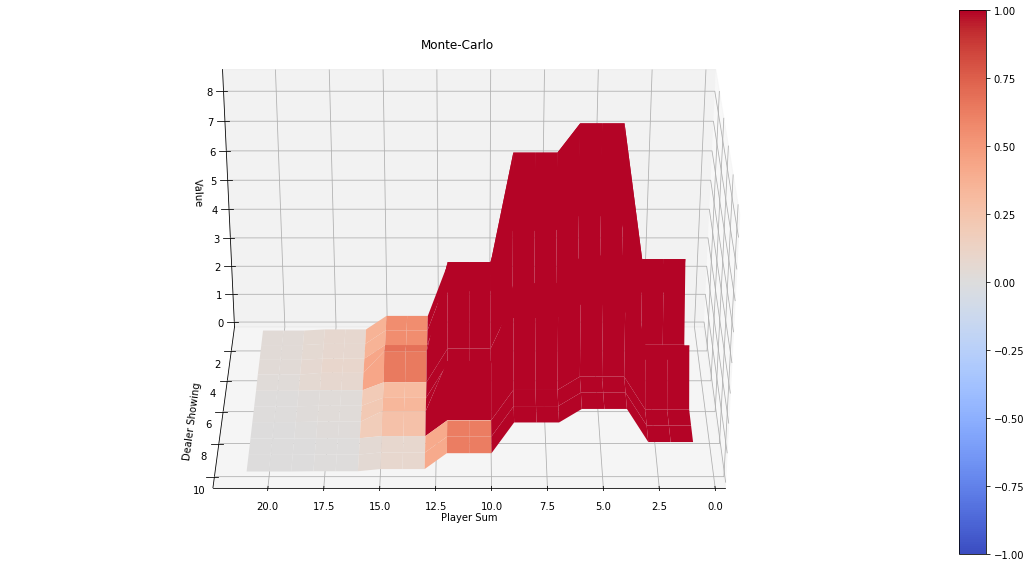

In [96]:

plt.clf() 
plot_value_function(get_value_from_theta(theta), degree= 90, title = "Monte-Carlo", cm = plt.cm.coolwarm)

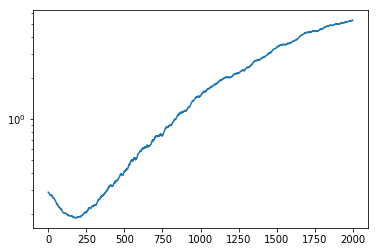

In [97]:
##MSE
plt.clf()
plt.plot([i for i in range(iterations)], MSEs)
plt.yscale("log")
plt.show()
